In [1]:
import os
# Force the threading layer to be compatible with Jupyter on macOS
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
import torch.nn as nn
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import digamma, gammaln
import tqdm

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
def generate_data(mu, tau, N):
  """Draw N samples from N(mu, tau^{-1}) and return them as a NumPy array.
  """
  if tau <= 0:
    raise ValueError("Precision tau must be positive.")

  std = np.sqrt(1.0 / tau)
  D = np.random.normal(loc=mu, scale=std, size=N)
  return D

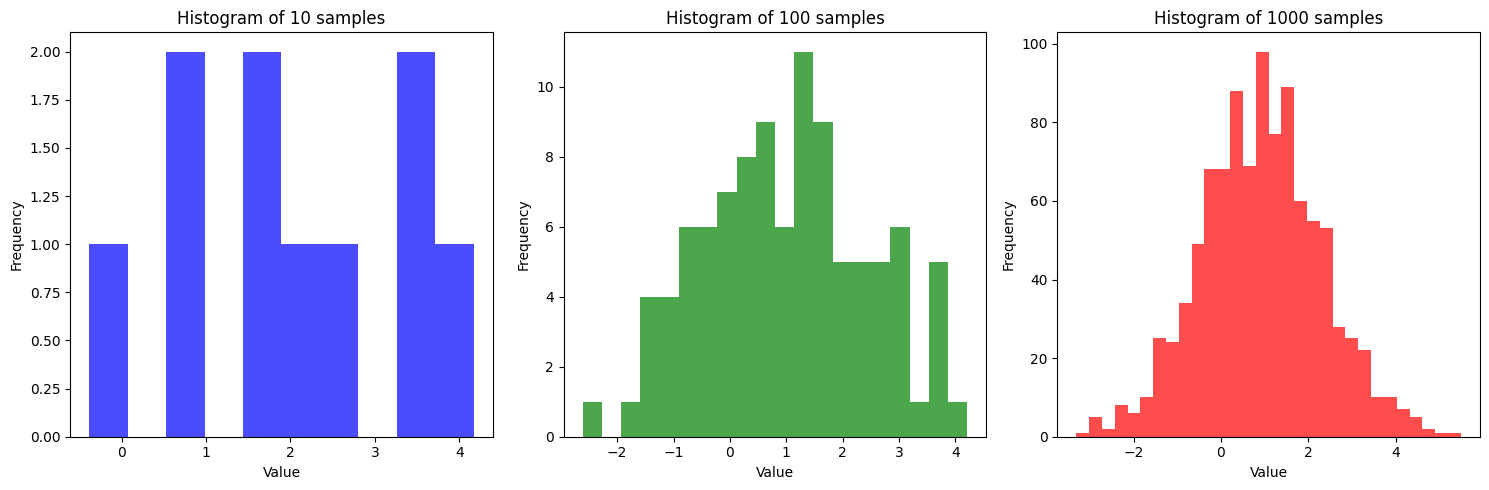

In [4]:
mu_true = 1
tau_true = 0.5
Dataset_1 = generate_data(mu_true, tau_true, 10)
Dataset_2 = generate_data(mu_true, tau_true, 100)
Dataset_3 = generate_data(mu_true, tau_true, 1000)

#Make them into tensors:
dataset_1 = torch.tensor(Dataset_1, dtype = torch.float32)
dataset_2 = torch.tensor(Dataset_2, dtype = torch.float32)
dataset_3 = torch.tensor(Dataset_3, dtype = torch.float32)


#Visualize the datasets/true distribution:
#Plot histograms of the data:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataset_1, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of 10 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataset_2, bins=20, alpha=0.7, color='green')
plt.title('Histogram of 100 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataset_3, bins=30, alpha=0.7, color='red')
plt.title('Histogram of 1000 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [5]:
class Normal_BBVI(nn.Module):
    def __init__(self, mu_0 = 1, lambda_0 = 0.1, a_0 = 1, b_0 = 2):
        super(Normal_BBVI, self).__init__()
        # Initialize mu and log_sigma as learnable parameters
        self.mu_0 = mu_0
        self.lambda_0 = lambda_0
        self.a_0 = a_0
        self.b_0 = b_0

        #Parameters for variatioalnal distributions:
        # q(mu) - Normal(loc,scale)
        self.q_mu_loc = nn.Parameter(torch.tensor(np.random.randn()))
        self.q_mu_scale_raw = nn.Parameter(torch.tensor((1.0)))  

        # q(tau) - Gamma(concentration, rate)
        self.q_tau_concentration_raw = nn.Parameter(torch.tensor(1.0))
        self.q_tau_rate_raw = nn.Parameter(torch.tensor(1.0))

    @property
    def q_mu_scale(self):
        return torch.nn.functional.softplus(self.q_mu_scale_raw)
    @property
    def q_tau_conc(self):
        return torch.nn.functional.softplus(self.q_tau_concentration_raw)
    @property
    def q_tau_rate(self):
        return torch.nn.functional.softplus(self.q_tau_rate_raw)
    

    def sample_q(self, num_samples):
        q_mu = dist.Normal(self.q_mu_loc, self.q_mu_scale)
        q_tau = dist.Gamma(self.q_tau_conc, self.q_tau_rate)

        mu_samples = q_mu.rsample((num_samples,)).detach()
        tau_samples = q_tau.rsample((num_samples,)).detach()

        log_q_mu = q_mu.log_prob(mu_samples)
        log_q_tau = q_tau.log_prob(tau_samples)

        return mu_samples, tau_samples, log_q_mu, log_q_tau
        
    def log_joint(self, x, mu, tau):
        """Compute the log joint probability log p(x, mu, tau).
        """
        #Get parameters:
        mu_0, lambda_0 = self.mu_0, self.lambda_0
        a_0, b_0 = self.a_0, self.b_0
        # Prior p(mu)
        mu_prior_scale = torch.sqrt(1.0 / (lambda_0 * tau))
        prior_mu = dist.Normal(mu_0, mu_prior_scale)
        log_p_mu = prior_mu.log_prob(mu)

        # Prior p(tau)
        prior_tau = dist.Gamma(a_0, b_0)
        log_p_tau = prior_tau.log_prob(tau)

        # Scale:
        scale = 1.0 / torch.sqrt(tau)

        #Reshape for broadcasting:
        mu_exp = mu.unsqueeze(1)  #
        scale_exp = scale.unsqueeze(1)  #
        x_exp = x.unsqueeze(0)  # Shape: (1, N)

        # Likelihood p(x | mu, tau)
        likelihood = dist.Normal(mu_exp, scale_exp)
        log_p_x_given_mu_tau = likelihood.log_prob(x_exp).sum(dim=1)

        return log_p_mu + log_p_tau + log_p_x_given_mu_tau


    def compute_scores(self, mu_s, tau_s):
        """Compute the score functions for q(mu) and q(tau).
        """
        #Parameters:
        mu_loc = self.q_mu_loc.detach()
        mu_scale = self.q_mu_scale.detach()
        tau_conc = self.q_tau_conc.detach()
        tau_rate = self.q_tau_rate.detach()

        score_mu_wrt_loc = (mu_s - mu_loc) / (mu_scale ** 2)
        score_mu_wrt_scale = -1/mu_scale + ((mu_s - mu_loc) ** 2) / (mu_scale ** 3)

        score_wrt_a = - digamma(tau_conc) + torch.log(tau_rate) + torch.log(tau_s)
        score_wrt_b = tau_conc / tau_rate - tau_s

        return score_mu_wrt_loc, score_mu_wrt_scale, score_wrt_a, score_wrt_b
        

### Naive BBVI Implementation:


In [6]:
def train_model(model, optimizer, x_data, steps = 2500, n_mc_samples=50):
    history ={'ELBO': [], 'mu': [], 'tau': []}
    print(f"Training regular BBVI:")
    #Add so tqdm writes elbo:
    with tqdm.tqdm(total=steps, desc = "Training") as pbar:
        for step in range(steps):
            optimizer.zero_grad()

            #1. Sample and evaluuate q(mu) and q(tau)
            mu_samples, tau_samples, log_q_mu, log_q_tau = model.sample_q(n_mc_samples)
            log_q = log_q_mu + log_q_tau

            # 2. Compute Log P (Reward)
            with torch.no_grad():
                log_p = model.log_joint(x_data, mu_samples, tau_samples)
            
            # 3. Algorithm 1 Loss Naive REINFORCE
            rewards = log_p - log_q.detach()
            loss = - torch.mean(rewards * log_q)

            loss.backward()
            optimizer.step()

            # Track progress
            with torch.no_grad():
                elbo = torch.mean(log_p - log_q).item()
                e_mu = model.q_mu_loc.item()
                e_tau = (model.q_tau_conc / model.q_tau_rate).item()

                history['ELBO'].append(elbo)
                history['mu'].append(e_mu)
                history['tau'].append(e_tau)
            if step % 1000 == 0:
                pbar.set_postfix({'ELBO': elbo, 'E[mu]': e_mu, 'E[tau]': e_tau})
            pbar.update(1)
                #print(f"Step {step}: ELBO = {elbo:.4f}, E[mu] = {e_mu:.4f}, E[tau] = {e_tau:.4f}")
    return history

In [7]:
n_iter = 1e4
n_mc_samples = 50
learning_rate = 1e-3
all_histories = []
for dataset in [dataset_1, dataset_2, dataset_3]:
    model = Normal_BBVI()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = train_model(model, optimizer, dataset, steps = int(n_iter), n_mc_samples=n_mc_samples)
    all_histories.append(history)



Training regular BBVI:


Training: 100%|██████████| 10000/10000 [00:04<00:00, 2110.77it/s, ELBO=-21.2, E[mu]=2.02, E[tau]=0.61]  


Training regular BBVI:


Training: 100%|██████████| 10000/10000 [00:04<00:00, 2132.83it/s, ELBO=-200, E[mu]=1.06, E[tau]=0.543]


Training regular BBVI:


Training: 100%|██████████| 10000/10000 [00:05<00:00, 1969.51it/s, ELBO=-1.91e+3, E[mu]=0.93, E[tau]=0.608]


In [8]:
def plot_results(history, x_data, true_params, i =0, cv = False):
    true_loc_gen, true_tau_gen, = true_params

    plt.figure(figsize=(14, 5))

    # --- A. ELBO ---
    plt.subplot(1, 3, 1)
    elbo_ma = np.convolve(history['ELBO'], np.ones(50) / 50, mode='valid')
    plt.plot(history['ELBO'], alpha=0.2, color='gray')
    plt.plot(elbo_ma, color='blue')
    plt.title("ELBO (Maximization)")
    plt.xlabel("Step")

    # --- B. Trajectories ---
    plt.subplot(1, 3, 2)
    plt.plot(history['mu'], label='Learned E[mu]', color='blue')
    plt.plot(history['tau'], label='Learned E[tau]', color='green')

    plt.axhline(true_loc_gen, color='blue', linestyle='--', alpha=0.5, label='True Loc')
    plt.axhline(true_tau_gen, color='green', linestyle='--', alpha=0.5, label='True Tau')

    plt.title("Parameter Trajectories")
    plt.legend()

    # --- C. Distribution Fit ---
    plt.subplot(1, 3, 3)

    # Data Histogram
    plt.hist(x_data.numpy(), bins=30, density=True, alpha=0.4, color='gray', label='Data')

    x_range = np.linspace(x_data.min() - 1, x_data.max() + 1, 500)

    # True Generating PDF
    true_scale_gen = 1.0 / np.sqrt(true_tau_gen)
    pdf_true = norm.pdf(x_range, loc=true_loc_gen, scale=true_scale_gen)
    plt.plot(x_range, pdf_true, 'k--', label='True Generator')

    # Learned Model PDF (Skew Normal)
    final_mu = history['mu'][-1]
    final_tau = history['tau'][-1]
    final_scale = 1.0 / np.sqrt(final_tau)

    pdf_learned = norm.pdf(x_range, loc=final_mu, scale=final_scale)
    plt.plot(x_range, pdf_learned, 'r-', linewidth=2, label='Learned Normal')
    plt.title("Posterior Approximation")
    plt.legend(fontsize='small')

    plt.tight_layout()
    # if i == 2:
    #     if not cv:
    #         #Save figure in Plots/
    #         plt.savefig(f'Plots/BBVI_Normal_Fit_{x_data.shape[0]}_samples.png', dpi=300)
    #     if cv:
    #         #Save figure in Plots/
    #         plt.savefig(f'Plots/BBVI_Normal_Fit_CV_{x_data.shape[0]}_samples.png', dpi=300)
    plt.show()
    

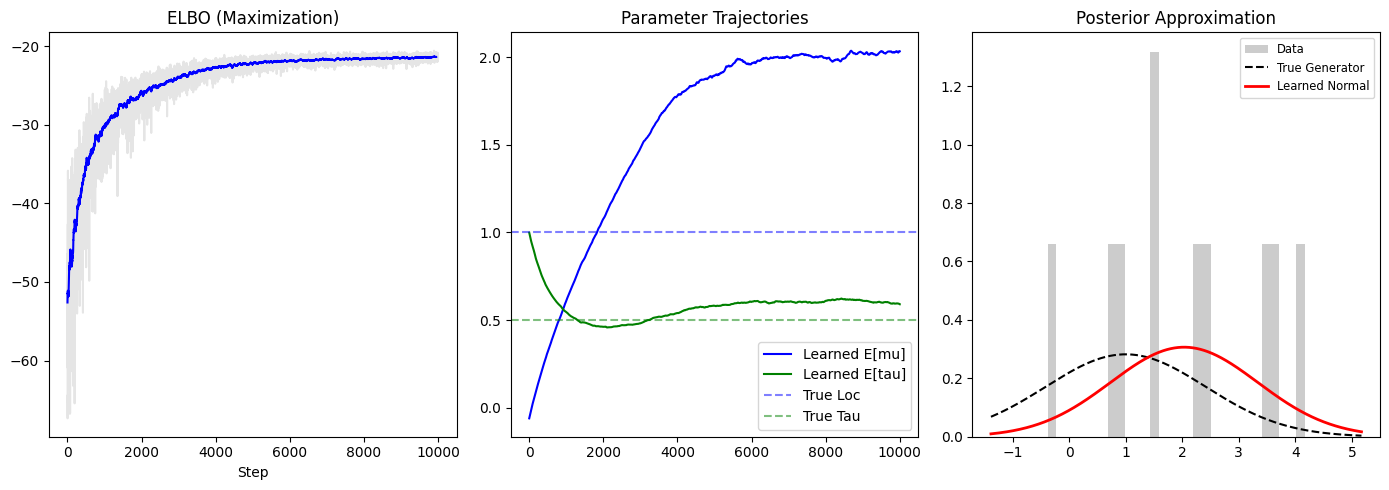

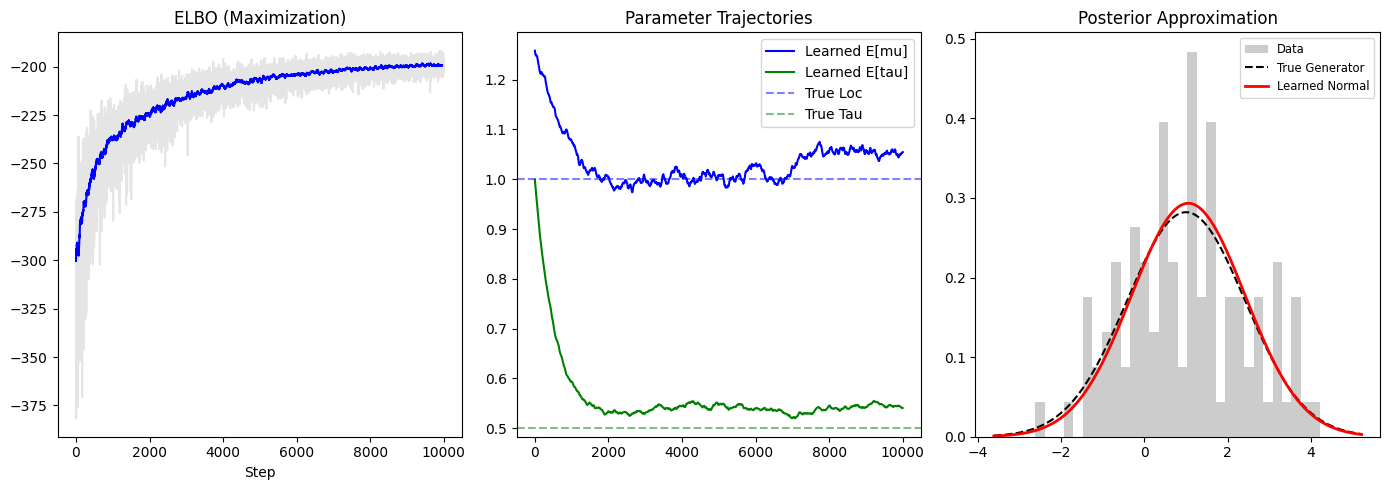

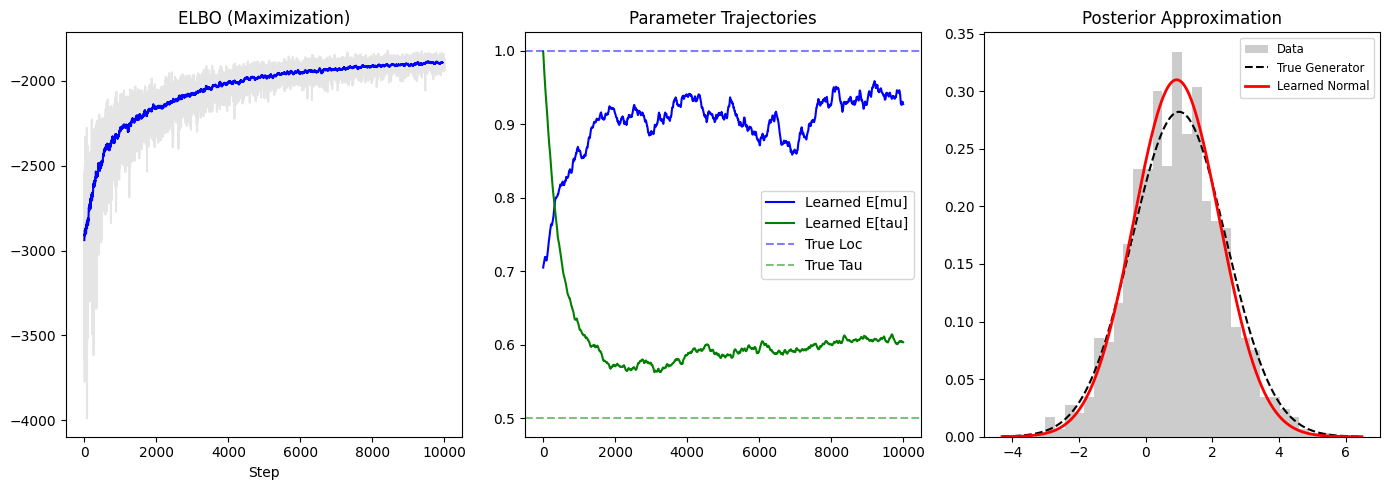

In [9]:
i = 1
for history, x_data in zip(all_histories, [dataset_1, dataset_2, dataset_3]):
    plot_results(history, x_data, (mu_true, tau_true), i=i)
    i += 1

## BBVI with Control Variate (CV):
### first we create the training loop:

In [10]:
def train_model_cv_per_d(model:Normal_BBVI, optimizer, x_data, steps = 2500, n_mc_samples=50):
    history ={'ELBO': [], 'mu': [], 'tau': []}

    print(f"Training BBVI with Control Variates:")
    #Add so tqdm writes elbo:

    with tqdm.tqdm(total=steps, desc = "Training") as pbar:
        for step in range(steps):
            optimizer.zero_grad()

            #1. Sample and evaluuate q(mu) and q(tau)
            mu_samples, tau_samples, log_q_mu, log_q_tau = model.sample_q(n_mc_samples)

            # Compute Score functions:
            scores = model.compute_scores(mu_samples, tau_samples)
            log_q = torch.stack([log_q_mu, log_q_tau], dim=0)

            # 2. Compute Log P (Reward)
            with torch.no_grad():
                log_p = model.log_joint(x_data, mu_samples, tau_samples)
            
            # 3. Algorithm 2 (Control Variates) loss
            R_mu = log_p - log_q_mu.detach()
            R_tau = log_p - log_q_tau.detach()
            R_d_list = [R_mu, R_mu, R_tau, R_tau]

            f_d_list = []
            for d in range(4):
                f_d = R_d_list[d] * scores[d]
                f_d_list.append(f_d)
            
            #get h (score functions)
            h_d = []
            for d in range(4):
                h_d.append(scores[d])

            a_d_list = []
            for d in range(4):
                cat_fh_d = torch.cat([f_d_list[d].unsqueeze(1), h_d[d].unsqueeze(1)], dim=1)
                a_d = torch.cov(cat_fh_d) / torch.var(h_d[d])
                a_d_list.append(a_d.detach())


            loss_list = []
            tot_loss = 0.0
            for d in range(4):
                loss_d = -torch.mean(f_d_list[d] - torch.matmul(a_d_list[d], h_d[d]))
                loss_list.append(loss_d)
                tot_loss += loss_d
            
            model.q_mu_loc.grad = loss_list[0]
            model.q_mu_scale_raw.grad = loss_list[1]
            model.q_tau_concentration_raw.grad = loss_list[2]
            model.q_tau_rate_raw.grad = loss_list[3]

            optimizer.step()

            # Track progress
            with torch.no_grad():
                elbo = torch.mean(log_p - log_q).item()
                e_mu = model.q_mu_loc.item()
                e_tau = (model.q_tau_conc / model.q_tau_rate).item()

                history['ELBO'].append(elbo)
                history['mu'].append(e_mu)
                history['tau'].append(e_tau)
            if step % 1000 == 0:
                pbar.set_postfix({'ELBO': elbo, 'E[mu]': e_mu, 'E[tau]': e_tau})
            pbar.update(1)
    return history

In [11]:
n_iter = 1e4
n_mc_samples = 50
learning_rate = 1e-3
all_histories_cv = []
for dataset in [dataset_1, dataset_2, dataset_3]:
    model_cv = Normal_BBVI()
    optimizer_cv = torch.optim.Adam(model_cv.parameters(), lr=learning_rate)
    history_cv = train_model_cv_per_d(model_cv, optimizer_cv, dataset, steps = int(n_iter), n_mc_samples=n_mc_samples)
    all_histories_cv.append(history_cv)

Training BBVI with Control Variates:


Training:   0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/pm/1gbbgm994d3fgrqz_vmjbwbw0000gn/T/ipykernel_57823/405594482.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  score_wrt_a = - digamma(tau_conc) + torch.log(tau_rate) + torch.log(tau_s)
Training: 100%|██████████| 10000/10000 [00:05<00:00, 1887.37it/s, ELBO=-23.1, E[mu]=1.62, E[tau]=0.484] 


Training BBVI with Control Variates:


Training: 100%|██████████| 10000/10000 [00:05<00:00, 1924.08it/s, ELBO=-210, E[mu]=1.04, E[tau]=0.56]


Training BBVI with Control Variates:


Training: 100%|██████████| 10000/10000 [00:05<00:00, 1850.60it/s, ELBO=-1.89e+3, E[mu]=0.921, E[tau]=0.619]


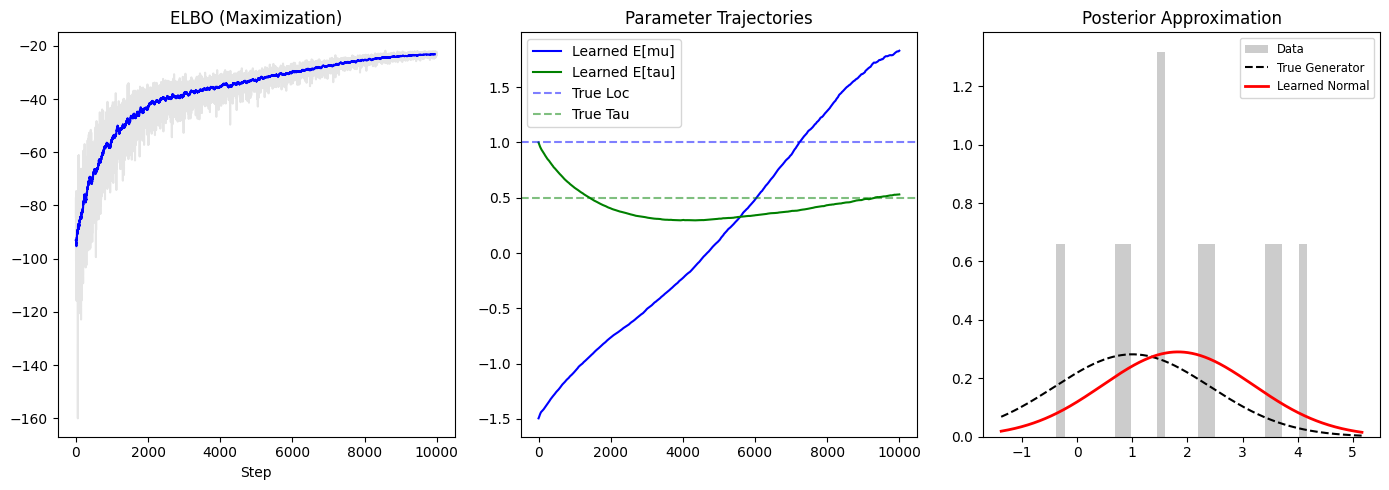

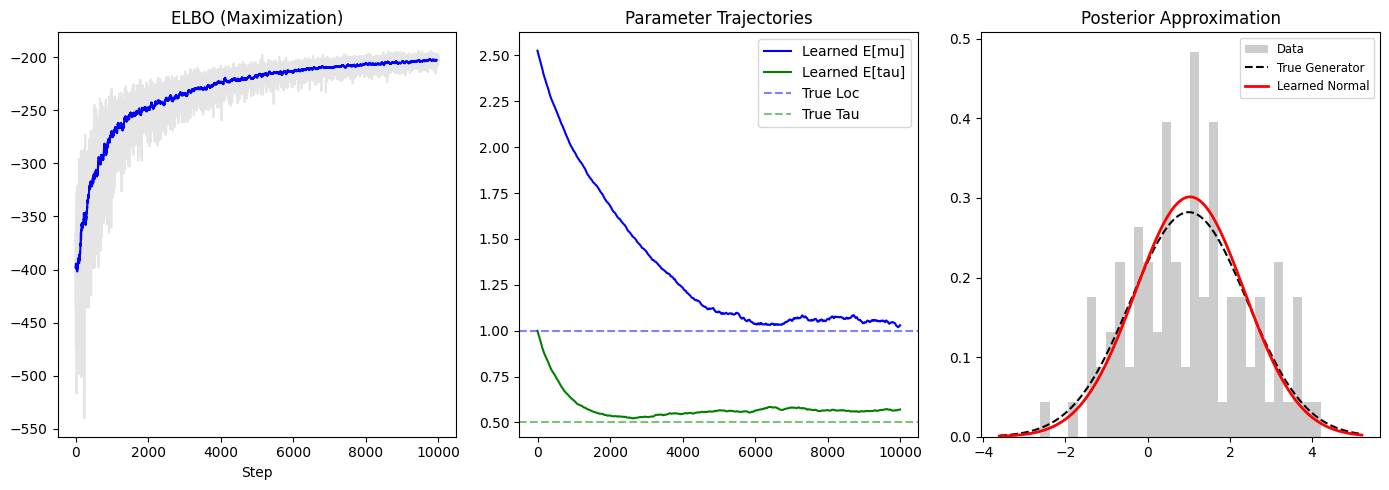

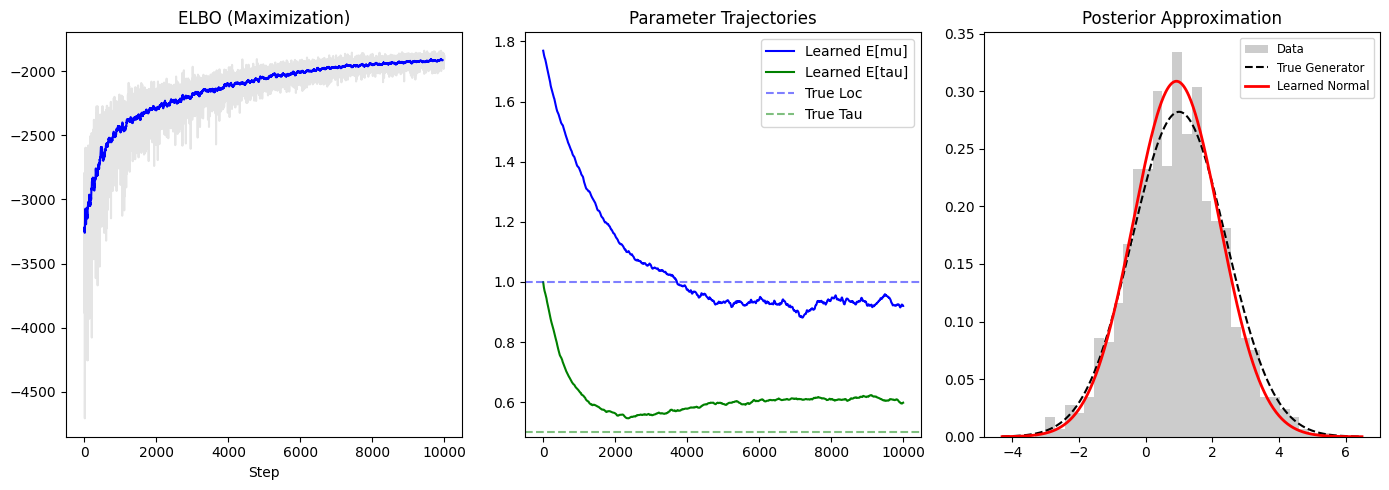

In [12]:
#plot results for CV model
i = 1
for history, x_data in zip(all_histories_cv, [dataset_1, dataset_2, dataset_3]):
    plot_results(history, x_data, (mu_true, tau_true), i=i, cv=True)
    i += 1